In [1]:
import dask.dataframe as dd
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

# set neat seaborn whitegrid styles for matplotlib charts
plt.style.use('seaborn')
sns.set_style('whitegrid')

In [3]:
%%time

# set parquet data folder path
parquet_data_folder = '../data/crimes-2001-to-present.snappy.parq'
print('Loading crime data from: {}'.format(parquet_data_folder))

# load crimes parquet data into dask df
crimes = dd.read_parquet(parquet_data_folder, index='Date')

# load all data into memory
crimes = crimes.persist()
print('Crime data loaded into memory.')

Loading crime data from: ../data/crimes-2001-to-present.snappy.parq
Crime data loaded into memory.
Wall time: 10.2 s


In [4]:
%%time
# log records count and data frame/partitions stats
print('Chicago Crime data stats:')
print('---------------------------------------')
print('{:,} total records in {} partitions'.format(len(crimes), crimes.npartitions))
print('DataFrame size: {:,}'.format(crimes.size.compute()))

Chicago Crime data stats:
---------------------------------------
6,401,616 total records in 1 partitions
DataFrame size: 89,622,624
Wall time: 0 ns


In [5]:
# check data frame structure
crimes

,Block,PrimaryType,FBICode,Description,LocationDescription,CommunityArea,Beat,District,Ward,Arrest,Domestic,Latitude,Longitude,Year
npartitions=1,,,,,,,,,,,,,,
2001-01-01 00:00:00,object,category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],category[unknown],bool,bool,float64,float64,category[unknown]
2017-08-25 23:59:00,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [6]:
%%time
# preview crimes data with Date index
crimes.head(5)

Wall time: 0 ns


,Block,PrimaryType,FBICode,Description,LocationDescription,CommunityArea,Beat,District,Ward,Arrest,Domestic,Latitude,Longitude,Year
Date,,,,,,,,,,,,,,
2001-01-01,064XX S CAMPBELL AVE,OFFENSE INVOLVING CHILDREN,20,CRIM SEX ABUSE BY FAM MEMBER,RESIDENCE,66.0,825,8.0,15.0,False,True,41.777017,-87.686172,2001
2001-01-01,063XX S CENTRAL AV,OTHER OFFENSE,26,TELEPHONE THREAT,OTHER,NaN,813,8.0,NaN,False,False,41.777538,-87.761552,2001
2001-01-01,031XX W DOUGLAS BLVD,SEX OFFENSE,17,AGG CRIMINAL SEXUAL ABUSE,CHURCH/SYNAGOGUE/PLACE OF WORSHIP,29.0,1022,10.0,24.0,False,False,NaN,NaN,2001
2001-01-01,007XX N MICHIGAN AVE,THEFT,06,FINANCIAL ID THEFT: OVER $300,RESIDENCE,8.0,1833,18.0,42.0,False,False,41.896660,-87.624110,2001
2001-01-01,076XX S EMERALD AVE,THEFT,06,AGG: FINANCIAL ID THEFT,RESIDENCE,71.0,621,6.0,17.0,False,False,41.756087,-87.642812,2001


In [7]:
%%time

# get crime types
crime_types = crimes[['PrimaryType']]

# get crime counts by primary type
crime_type_total = crime_types.groupby('PrimaryType').size().compute()

# get arrests and domestic counts for each primary crime type
crime_type_counts = crimes[['PrimaryType', 'Arrest', 'Domestic']]\
.groupby('PrimaryType').sum().compute()

# add crime type totals column
crime_type_counts['Total'] = crime_type_total

# print all crime stats (arrests, domestic, and totals)
print(crime_type_counts.sort_values(by='Total', ascending=False))

                                     Arrest  Domestic    Total
PrimaryType                                                   
THEFT                              161206.0   31004.0  1336422
BATTERY                            268091.0  493984.0  1170982
CRIMINAL DAMAGE                     52256.0   55455.0   735055
NARCOTICS                          683386.0     245.0   687684
OTHER OFFENSE                       70194.0  115557.0   397375
ASSAULT                             92630.0   85388.0   393800
BURGLARY                            21364.0    2467.0   372293
MOTOR VEHICLE THEFT                 27796.0    1141.0   301173
ROBBERY                             23657.0    3902.0   242663
DECEPTIVE PRACTICE                  42641.0    2771.0   236939
CRIMINAL TRESPASS                  136845.0    5843.0   184854
PROSTITUTION                        66102.0       6.0    66362
WEAPONS VIOLATION                   51657.0     227.0    64252
PUBLIC PEACE VIOLATION              29623.0    2144.0  

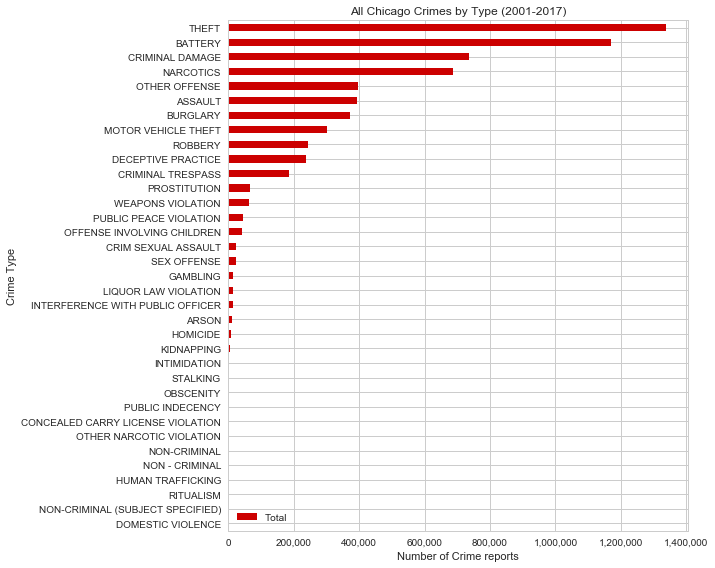

In [8]:
# plot crimes by primary type counts
all_crime_types = crime_type_counts.sort_values(by='Total', ascending=True)\
.drop(['Arrest', 'Domestic'], axis=1) # denotes column
all_crime_types.plot(kind='barh', figsize=(10,8), color='#cc0000')
plt.title('All Chicago Crimes by Type (2001-2017)')
plt.xlabel('Number of Crime reports')
plt.ylabel('Crime Type')
plt.tight_layout()
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

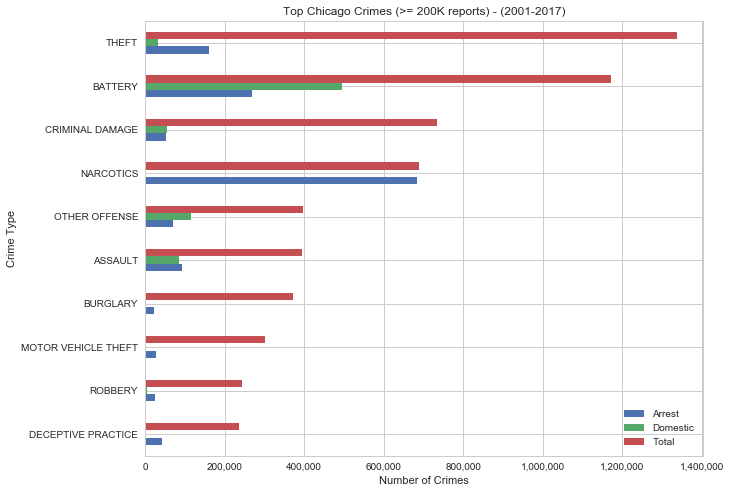

In [9]:
# plot top crimes (>-= 200,000 reports)
crime_type_counts[crime_type_counts['Total'] >= 200000].sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8))
plt.title('Top Chicago Crimes (>= 200K reports) - (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Crime Type')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [10]:
# get narcotics crimes
narcotics = crimes[crimes['PrimaryType']=='NARCOTICS']
#print(narcotics.head())

# get narcotics crime description counts
narcotics_crimes = narcotics[['PrimaryType', 'Description']]\
.groupby('Description').count().compute()\
.sort_values(by='PrimaryType', ascending=False)

print(narcotics_crimes.head(10))
print('...')
print('Total Narcotics Crime Descriptions: {}'.format(len(narcotics_crimes)))

                                PrimaryType
Description                                
POSS: CANNABIS 30GMS OR LESS         274724
POSS: CRACK                          117403
POSS: HEROIN(WHITE)                   88928
SOLICIT NARCOTICS ON PUBLICWAY        26144
POSS: COCAINE                         23964
MANU/DELIVER:CRACK                    23615
MANU/DELIVER: HEROIN (WHITE)          23531
POSS: CANNABIS MORE THAN 30GMS        16443
ATTEMPT POSSESSION NARCOTICS          16035
FOUND SUSPECT NARCOTICS               14976
...
Total Narcotics Crime Descriptions: 379


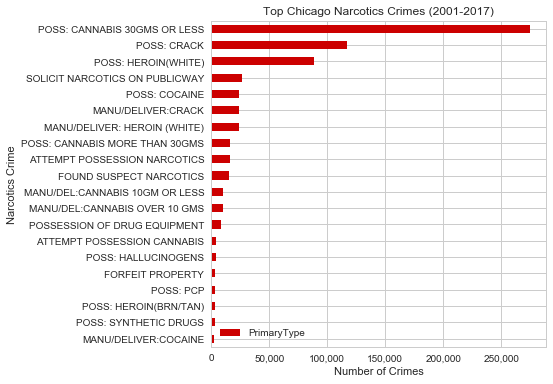

In [11]:
# plot top 20 narcotics crimes
narcotics_crimes[:20].sort_values(by='PrimaryType', ascending=True)\
.plot(kind='barh', figsize=(6,6), color='#cc0000')
plt.title('Top Chicago Narcotics Crimes (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Narcotics Crime')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [12]:
# get other offenses crimes
other_offenses = crimes[crimes['PrimaryType']=='OTHER OFFENSE']
#print(other_offenses.head())

# get other offense crime description counts
other_offense_crimes = other_offenses[['PrimaryType', 'Description']]\
.groupby('Description').count().compute()\
.sort_values(by='PrimaryType', ascending=False)

print(other_offense_crimes.head(10))
print('...')
print('Total Other Offense Crime Descriptions: {}'.format(len(other_offense_crimes)))

                                PrimaryType
Description                                
TELEPHONE THREAT                     129722
HARASSMENT BY TELEPHONE               97048
OTHER VEHICLE OFFENSE                 34483
VIOLATE ORDER OF PROTECTION           31547
HARASSMENT BY ELECTRONIC MEANS        20470
FALSE/STOLEN/ALTERED TRP              19577
OTHER CRIME INVOLVING PROPERTY        11170
OTHER WEAPONS VIOLATION                7101
VEHICLE TITLE/REG OFFENSE              6668
LICENSE VIOLATION                      6360
...
Total Other Offense Crime Descriptions: 379


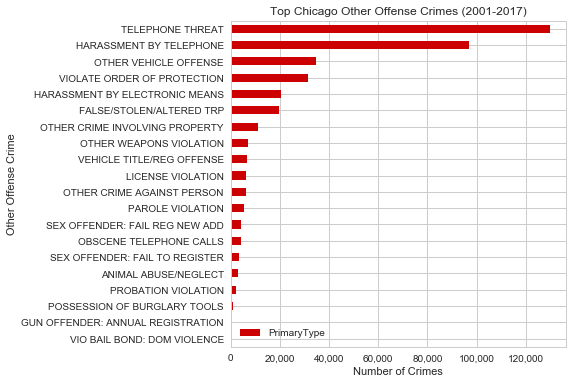

In [13]:
# plot top 20 other offense crimes
other_offense_crimes[:20].sort_values(by='PrimaryType', ascending=True)\
.plot(kind='barh', figsize=(6,6), color='#cc0000')
plt.title('Top Chicago Other Offense Crimes (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Other Offense Crime')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

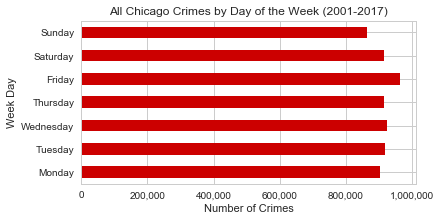

In [14]:
# plot crimes per day of the week
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
crimes.groupby([crimes.index.dayofweek]).size().compute()\
.plot(kind='barh', figsize=(6,3), color='#cc0000')
plt.title('All Chicago Crimes by Day of the Week (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Week Day')
plt.yticks(np.arange(7), days)
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

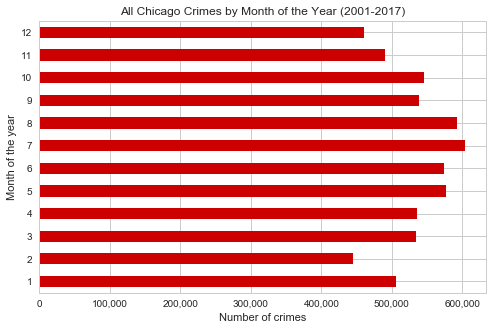

In [15]:
# plot crimes per month of the year
crimes.groupby([crimes.index.month]).size().compute()\
.plot(kind='barh', figsize=(8,5), color='#cc0000')
plt.title('All Chicago Crimes by Month of the Year (2001-2017)')
plt.xlabel('Number of crimes')
plt.ylabel('Month of the year')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [16]:
%%time
print('\nParsing All Crimes...')

# get monthly total crime counts
monthly_crime = crime_types.resample('M').count().compute()

# print monthly total crime stats
print('---------------------------------------')
print(monthly_crime.head())
print('...\nTotal Crime records: {:,}'.format(len(crimes)))
print('Total Months: {:,}'.format(monthly_crime.size))

# dataframe stats print util function
def print_dataframe_stats(df, title):
    print('\n{}\n---------------------------------------'.format(title))
    print(df.head())
    print('...\nTotal {}: {:,}'.format(title, df.size.compute()))

# get arrests
arrests = crimes[crimes['Arrest'] == True]['Arrest']
print_dataframe_stats(arrests, 'Arrests')

# get domestic crimes
domestic = crimes[crimes['Domestic'] == True]['Domestic']
print_dataframe_stats(domestic, 'Domestic')


Parsing All Crimes...
---------------------------------------
            PrimaryType
2001-01-31        38009
2001-02-28        33711
2001-03-31        40418
2001-04-30        40030
2001-05-31        41734
...
Total Crime records: 6,401,616
Total Months: 200

Arrests
---------------------------------------
Date
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
Name: Arrest, dtype: bool
...
Total Arrests: 1,796,176

Domestic
---------------------------------------
Date
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
2001-01-01    True
Name: Domestic, dtype: bool
...
Total Domestic: 831,992
Wall time: 1.62 s


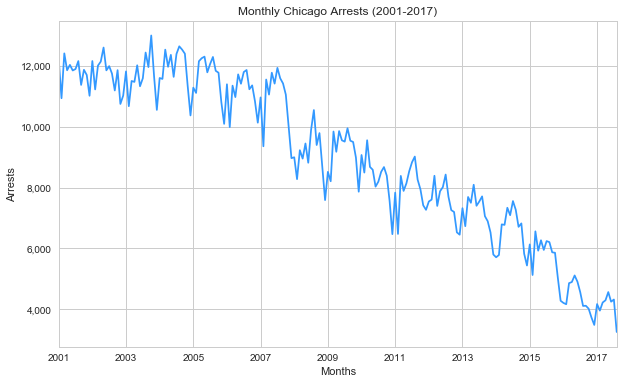

In [17]:
# plot monthly arrests
monthly_arrests = arrests.resample('M').sum().compute()
monthly_arrests.plot(figsize=(10,6), color='#3399ff')
plt.title('Monthly Chicago Arrests (2001-2017)')
plt.xlabel('Months')
plt.ylabel('Arrests')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

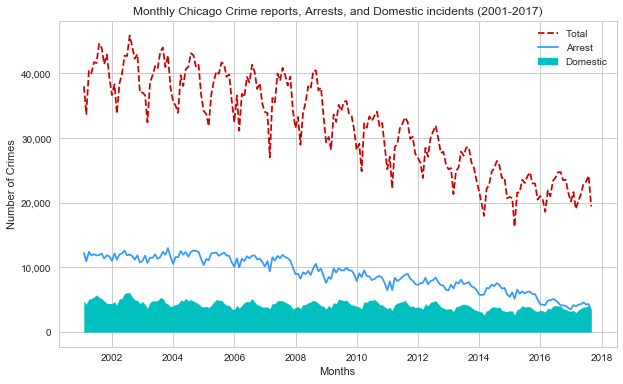

In [18]:
# get monthly domestic crimes
monthly_domestic = domestic.resample('M').sum().compute()

# plot monthly crime counts, arrests, and domestic incidents reports
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(monthly_crime.index, monthly_crime, '--', label='Total', color='#cc0000')
ax.plot(monthly_arrests.index, monthly_arrests, color='#3399ff', zorder=10)
ax.fill_between(monthly_domestic.index, monthly_domestic, \
                label='Domestic', color='c')
ax.set_xlabel('Months')
ax.set_ylabel('Number of Crimes')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.legend(loc='upper right')
plt.title('Monthly Chicago Crime reports, Arrests, and Domestic incidents (2001-2017)')
plt.show()

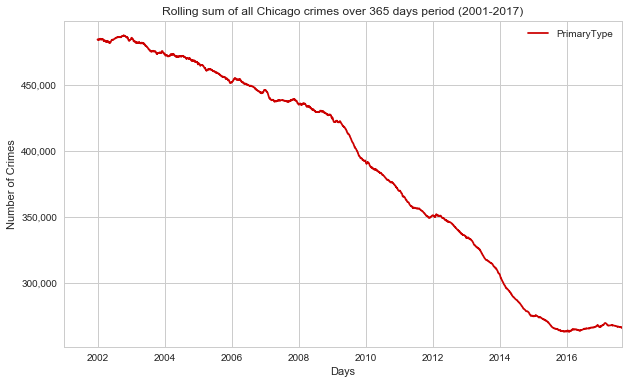

Wall time: 1.3 s


In [19]:
%%time
# get crimes rolling sum for a smoother crime decline chart display
crimes_rolling_sum = crime_types.resample('D').count().rolling(365).sum().compute()
crimes_rolling_sum.plot(figsize=(10,6), color='#cc0000')
plt.title('Rolling sum of all Chicago crimes over 365 days period (2001-2017)')
plt.xlabel('Days')
plt.ylabel('Number of Crimes')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [20]:
# get top crime types
top_crime_types = crime_type_counts[crime_type_counts['Total'] >= 200000]\
.sort_values(by='Total', ascending=False)
top_crime_types.head(10)

,Arrest,Domestic,Total
PrimaryType,,,
THEFT,161206.0,31004.0,1336422
BATTERY,268091.0,493984.0,1170982
CRIMINAL DAMAGE,52256.0,55455.0,735055
NARCOTICS,683386.0,245.0,687684
OTHER OFFENSE,70194.0,115557.0,397375
ASSAULT,92630.0,85388.0,393800
BURGLARY,21364.0,2467.0,372293
MOTOR VEHICLE THEFT,27796.0,1141.0,301173
ROBBERY,23657.0,3902.0,242663


In [21]:
%%time
print('Getting Top Crimes by Month...')

# get top crimes stats
# TODO: use isin and index by primary type to speed up this query?
top_crimes = crime_types[(crime_types['PrimaryType']=='THEFT') | \
                         (crime_types['PrimaryType']=='BATTERY') | \
                         (crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                         (crime_types['PrimaryType']=='NARCOTICS') | \
                         (crime_types['PrimaryType']=='OTHER OFFENSE') | \
                         (crime_types['PrimaryType']=='ASSAULT') | \
                         (crime_types['PrimaryType']=='BURGLARY') | \
                         (crime_types['PrimaryType']=='MOTOR VEHICLE THEFT') | \
                         (crime_types['PrimaryType']=='ROBBERY') | \
                         (crime_types['PrimaryType']=='DECEPTIVE PRACTICE')]
#print(top_crimes.head(10))

# group top crimes by month and crime type
crimes_groupby = top_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
top_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(top_crime_data.head(10))
print('...')

# unstack top crimes type group for series plotting
top_crime_data = top_crime_data.unstack()
print(top_crime_data.head(2))
print('...')

Getting Top Crimes by Month...
Date        PrimaryType        
2001-01-31  OTHER OFFENSE          2797
            THEFT                  7852
            DECEPTIVE PRACTICE     1383
            CRIMINAL DAMAGE        3960
            ASSAULT                2122
            BATTERY                6520
            BURGLARY               1932
            MOTOR VEHICLE THEFT    2092
            ROBBERY                1396
            NARCOTICS              4708
Name: Count, dtype: int64
...
PrimaryType  OTHER OFFENSE  THEFT  DECEPTIVE PRACTICE  CRIMINAL DAMAGE  \
Date                                                                     
2001-01-31            2797   7852                1383             3960   
2001-02-28            2485   6660                1155             3656   

PrimaryType  ASSAULT  BATTERY  BURGLARY  MOTOR VEHICLE THEFT  ROBBERY  \
Date                                                                    
2001-01-31      2122     6520      1932                 2092    

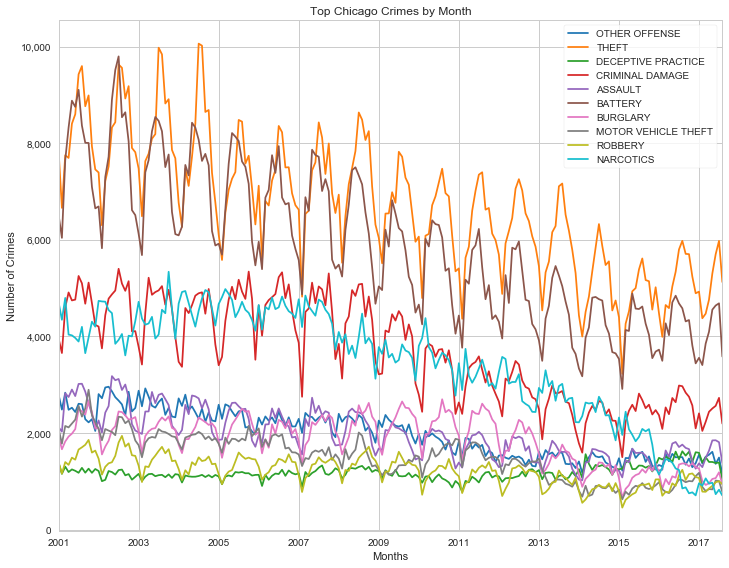

In [22]:
# plot top crimes data by month
top_crime_data.plot(figsize=(10,8), cmap='tab10')
plt.legend(loc='upper right', frameon=True)
plt.title('Top Chicago Crimes by Month')
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

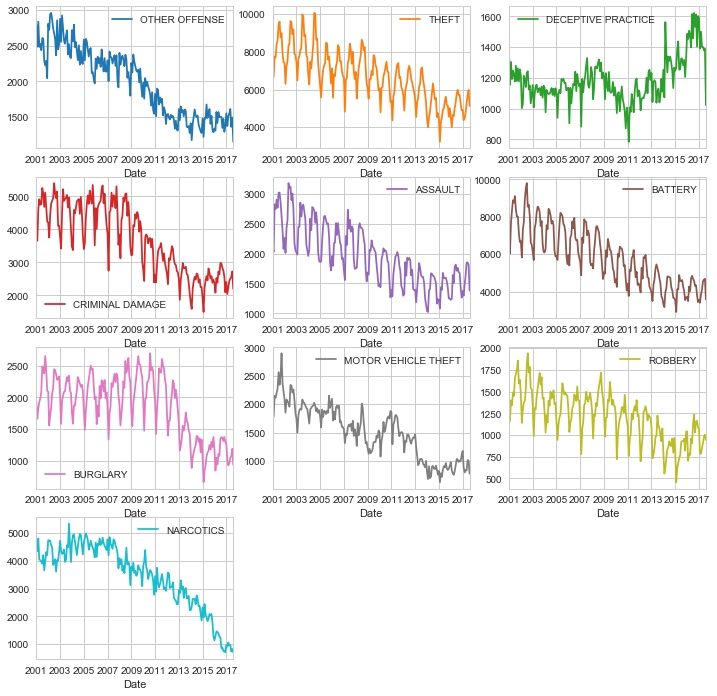

In [23]:
# plot top crimes grid
top_crime_data.plot(figsize=(12, 12), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [24]:
%%time
print('Getting Property Crimes by Month...')

# get top crimes stats
property_crimes = crime_types[(crime_types['PrimaryType']=='ARSON') | \
                         (crime_types['PrimaryType']=='BURGLARY') | \
                         (crime_types['PrimaryType']=='MOTOR VEHICLE THEFT') | \
                         (crime_types['PrimaryType']=='THEFT')]
#print(property_crimes.head(10))

# group property crimes by month and crime type
crimes_groupby = property_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
property_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(property_crime_data.head(10))
print('...')

# unstack top crimes type group for series plotting
property_crime_data = property_crime_data.unstack()
print(property_crime_data.head(2))
print('...')

Getting Property Crimes by Month...
Date        PrimaryType        
2001-01-31  THEFT                  7852
            BURGLARY               1932
            MOTOR VEHICLE THEFT    2092
            ARSON                    67
2001-02-28  THEFT                  6660
            BURGLARY               1664
            MOTOR VEHICLE THEFT    1779
            ARSON                    57
2001-03-31  THEFT                  7751
            BURGLARY               1825
Name: Count, dtype: int64
...
PrimaryType  THEFT  BURGLARY  MOTOR VEHICLE THEFT  ARSON
Date                                                    
2001-01-31    7852      1932                 2092     67
2001-02-28    6660      1664                 1779     57
...
Wall time: 875 ms


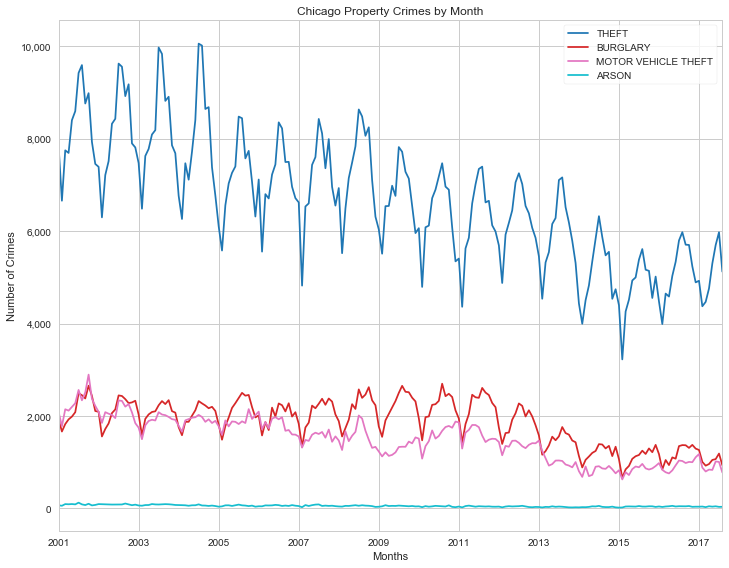

In [25]:
# plot property crimes data by month
property_crime_data.plot(figsize=(10,8), cmap='tab10')
plt.legend(loc='upper right', frameon=True)
plt.title('Chicago Property Crimes by Month')
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

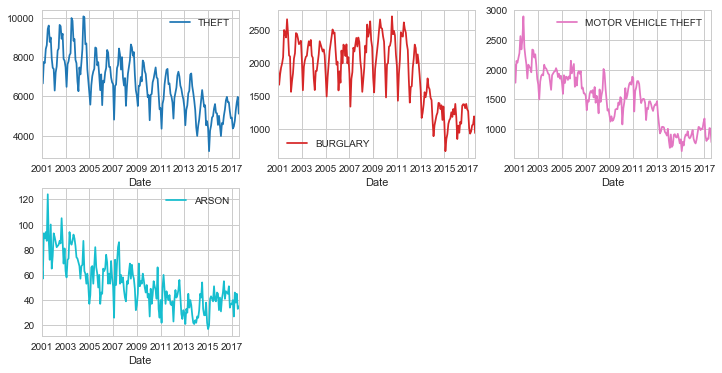

In [26]:
# plot property crimes grid
property_crime_data.plot(figsize=(12, 6), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [27]:
%%time
print('Getting Quality of Life Crimes by Month...')

# get top crimes stats
q_of_life_crimes = crime_types[(crime_types['PrimaryType']=='CRIMINAL DAMAGE') | \
                         (crime_types['PrimaryType']=='NARCOTICS') | \
                         (crime_types['PrimaryType']=='PROSTITUTION')]
#print(q_of_life_crimes.head(10))

# group quality of life crimes by month and crime type
crimes_groupby = q_of_life_crimes.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
q_of_life_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(q_of_life_crime_data.head(10))
print('...')

# unstack top crimes type group for series plotting
q_of_life_crime_data = q_of_life_crime_data.unstack()
print(q_of_life_crime_data.head(2))
print('...')

Getting Quality of Life Crimes by Month...
Date        PrimaryType    
2001-01-31  CRIMINAL DAMAGE    3960
            NARCOTICS          4708
            PROSTITUTION        560
2001-02-28  CRIMINAL DAMAGE    3656
            NARCOTICS          4344
            PROSTITUTION        421
2001-03-31  CRIMINAL DAMAGE    4602
            NARCOTICS          4797
            PROSTITUTION        540
2001-04-30  CRIMINAL DAMAGE    4910
Name: Count, dtype: int64
...
PrimaryType  CRIMINAL DAMAGE  NARCOTICS  PROSTITUTION
Date                                                 
2001-01-31              3960       4708           560
2001-02-28              3656       4344           421
...
Wall time: 656 ms


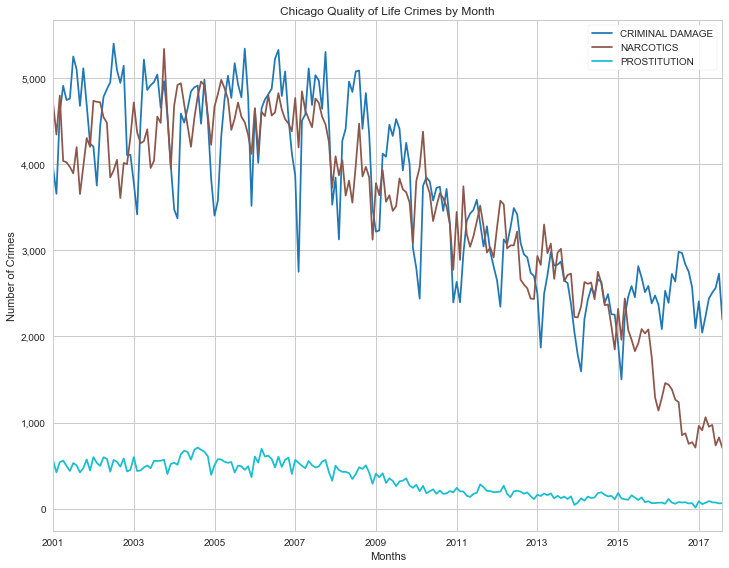

In [28]:
# plot quality of life crimes data by month
q_of_life_crime_data.plot(figsize=(10,8), cmap='tab10')
plt.legend(loc='upper right', frameon=True)
plt.title('Chicago Quality of Life Crimes by Month')
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

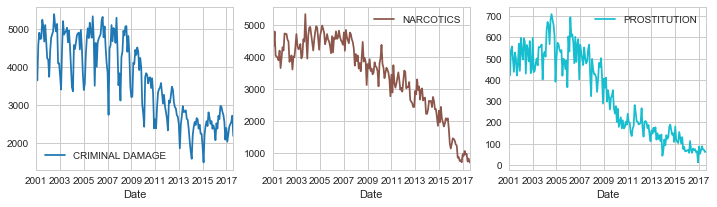

In [29]:
# plot quality of life crimes grid
q_of_life_crime_data.plot(figsize=(12, 3), subplots=True, layout=(-1, 3),\
                    cmap='tab10', sharex=False, sharey=False)
plt.show()

In [30]:
%%time
# get all crime data by month and primary type
crimes_groupby = crime_types.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
all_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print(all_crime_data.head(10))
print('...')

# unstack all crimes data for series plotting
all_crime_data = all_crime_data.unstack()
print(all_crime_data.head(2))

Date        PrimaryType               
2001-01-31  OFFENSE INVOLVING CHILDREN     239
            OTHER OFFENSE                 2797
            SEX OFFENSE                    185
            THEFT                         7852
            DECEPTIVE PRACTICE            1383
            CRIM SEXUAL ASSAULT            162
            CRIMINAL DAMAGE               3960
            ASSAULT                       2122
            BATTERY                       6520
            BURGLARY                      1932
Name: Count, dtype: int64
...
PrimaryType  OFFENSE INVOLVING CHILDREN  OTHER OFFENSE  SEX OFFENSE   THEFT  \
Date                                                                          
2001-01-31                        239.0         2797.0        185.0  7852.0   
2001-02-28                        151.0         2485.0        149.0  6660.0   

PrimaryType  DECEPTIVE PRACTICE  CRIM SEXUAL ASSAULT  CRIMINAL DAMAGE  \
Date                                                                   

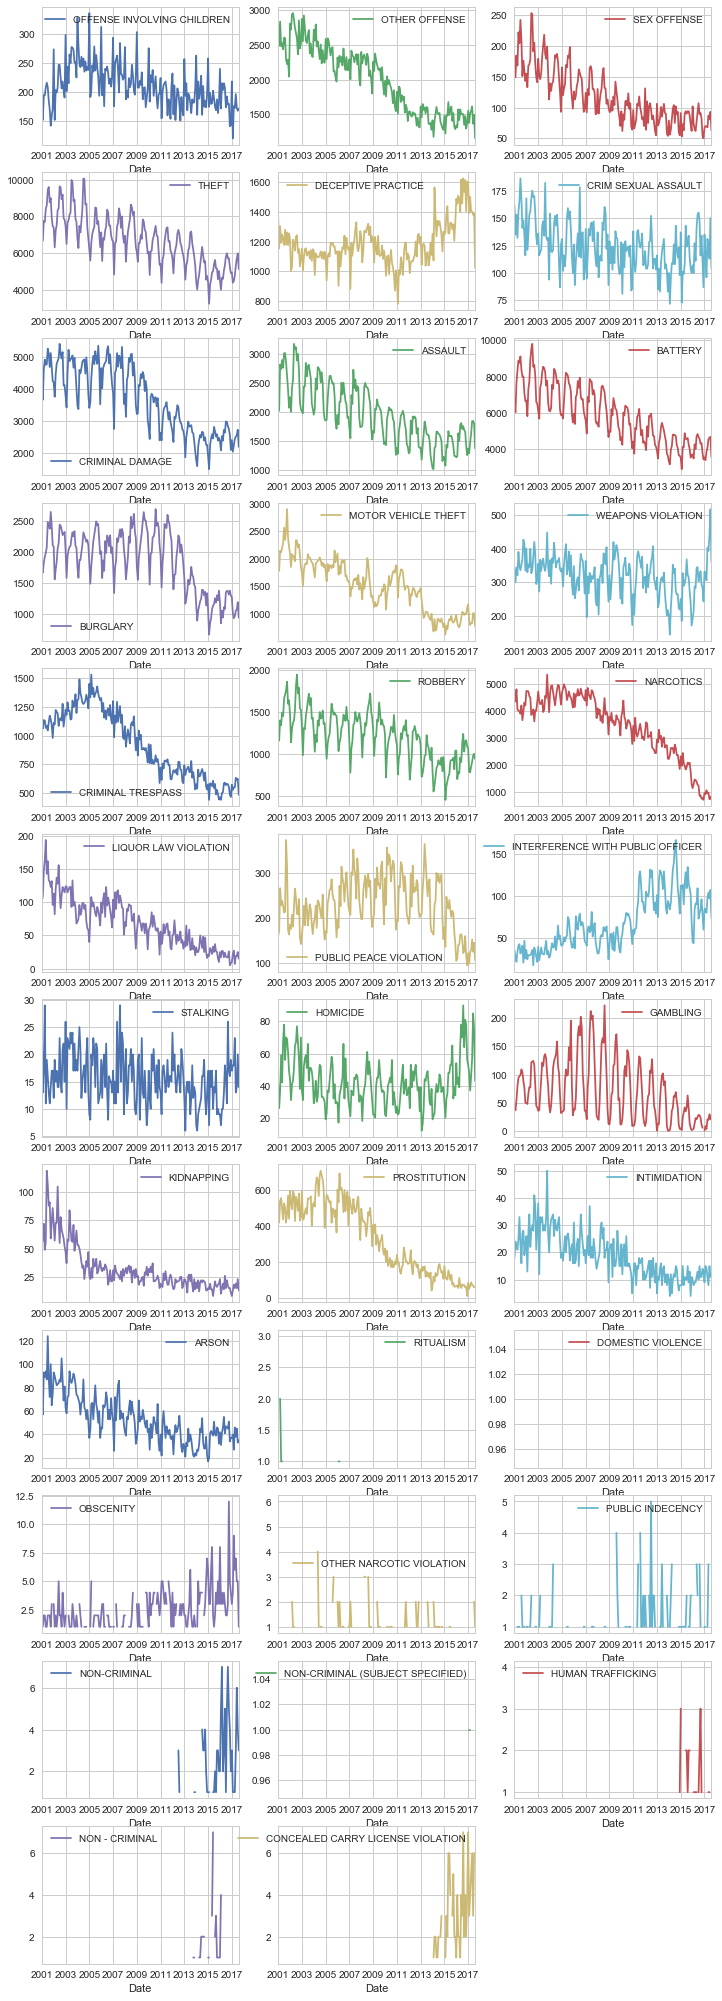

Wall time: 9.17 s


In [31]:
%%time
# plot all crimes over time individually
all_crime_data.plot(figsize=(12, 36), subplots=True, layout=(-1, 3),\
                    sharex=False, sharey=False)
plt.show()

In [32]:
# get crime location counts
crime_locations = crimes.groupby('LocationDescription').size().compute()
crime_locations = crime_locations.sort_values(ascending=False).rename('Total') #.reset_index()

# print crime location stats
print(crime_locations.head())
print("...\nTotal Locations: {:,}".format(crime_locations.size))

LocationDescription
STREET       1691235
RESIDENCE    1085715
APARTMENT     654736
SIDEWALK      637895
OTHER         242088
Name: Total, dtype: int64
...
Total Locations: 173


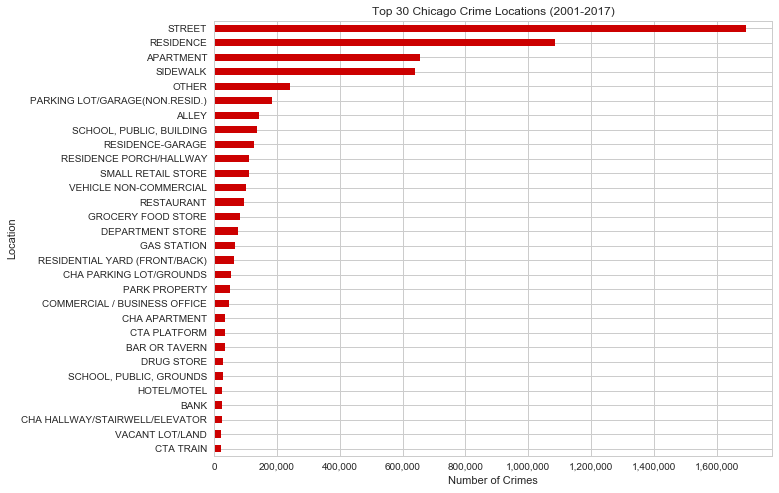

In [33]:
# plot top 30 crime locations
crime_locations[:30].sort_values(ascending=True)\
.plot(kind='barh', figsize=(10,8), color='#cc0000')
plt.title('Top 30 Chicago Crime Locations (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Location')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [34]:
# load Chicago community areas with pandas
# for plotting crime by Chicago 'sides'
community_areas = pd.read_csv('../data/chicago-community-areas.csv') #, index_col='CommunityName')
community_areas.head()

# get community crime stats
community_areas['Total'] = crimes.groupby('CommunityArea').size().compute().rename('Total')
community_crime = community_areas.sort_values(by='Total', ascending=False).dropna()

# print community crime stats
print(community_crime.head())
print("...\nTotal Communities: {:,}".format(community_crime.Total.count()))

    CommunityArea    CommunityName        Side   Total
25             25           Austin   West Side  370680
8               8  Near North Side     Central  192403
43             43      South Shore  South Side  189126
23             23    Humboldt Park   West Side  183219
24             24        West Town   West Side  171884
...
Total Communities: 77


D:\tools\dev\python\Anaconda3-4.2.0\lib\site-packages\pandas\core\indexes\category.py:138: RuntimeWarning: Values and categories have different dtypes. Did you mean to use
'Categorical.from_codes(codes, categories)'?
  data = Categorical(data, categories=categories, ordered=ordered)


In [35]:
# drop unused columns and reindex
community_crime = community_crime.drop(['CommunityArea', 'Side'], axis=1) # denotes column
community_crime = community_crime.set_index('CommunityName')
community_crime.head()

,Total
CommunityName,
Austin,370680
Near North Side,192403
South Shore,189126
Humboldt Park,183219
West Town,171884


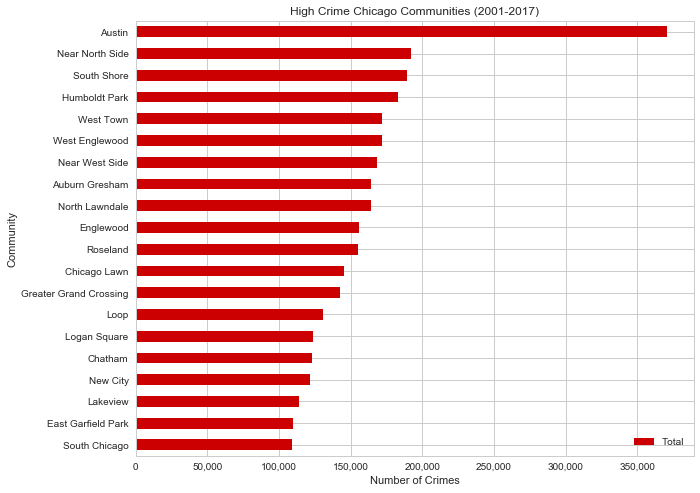

In [36]:
# plot 20 high crime communities
community_crime.head(20).sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(10,8), color='#cc0000')
plt.title('High Crime Chicago Communities (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [37]:
# get Austin community crime stats to see why it is so high
Austin_crime = crimes[crimes['CommunityArea']==25]\
.drop(['CommunityArea', 'Year'], axis=1) # denotes column

# get Austin crimes by block
Austin_crime_blocks = Austin_crime[['Block']]\
.groupby('Block').size().compute()\
.sort_values(ascending=False)

print('Top Austin community crime blocks:')
print(Austin_crime_blocks.head(20))
print('...\nTotal blocks: {}'.format(len(Austin_crime_blocks)))

Top Austin community crime blocks:
Block
046XX W NORTH AVE          2883
051XX W MADISON ST         2563
003XX N CENTRAL AVE        2459
048XX W NORTH AVE          2199
052XX W MADISON ST         2028
002XX N PINE AVE           1935
051XX W CHICAGO AVE        1847
055XX W NORTH AVE          1773
003XX S CICERO AVE         1743
055XX W WASHINGTON BLVD    1621
051XX W NORTH AVE          1609
050XX W WASHINGTON BLVD    1531
049XX W NORTH AVE          1525
001XX N PINE AVE           1504
056XX W MADISON ST         1443
055XX W CONGRESS PKWY      1438
050XX W MADISON ST         1433
001XX N LOTUS AVE          1422
053XX W MADISON ST         1380
054XX W WASHINGTON BLVD    1365
dtype: int64
...
Total blocks: 1227


In [38]:
# get Austin crimes by type
Austin_crime_by_type = Austin_crime[['PrimaryType']]\
.groupby('PrimaryType').size().compute().rename('Total')\
.sort_values(ascending=False)
print('Austin community crimes by type:')
print(Austin_crime_by_type)

print('\nTop Austin community crimes:')
print(Austin_crime_by_type.index[:24])

# group top Austin crimes by month and crime type
crimes_groupby = Austin_crime[Austin_crime['PrimaryType'].isin(Austin_crime_by_type.index[:24])]\
.groupby([pd.TimeGrouper('M'), 'PrimaryType'])
Austin_crime_data = crimes_groupby['PrimaryType'].count().compute().rename('Count')
print('\nAustin community crime by month:')
print(Austin_crime_data.head(10))
print('...')

# unstack top crimes type group for series plotting
Austin_crime_data = Austin_crime_data.unstack()
Austin_crime_data.tail()

Austin community crimes by type:
PrimaryType
NARCOTICS                            87280
BATTERY                              73638
THEFT                                47963
CRIMINAL DAMAGE                      32492
OTHER OFFENSE                        22181
ASSAULT                              21924
ROBBERY                              15618
BURGLARY                             14830
MOTOR VEHICLE THEFT                  13960
DECEPTIVE PRACTICE                    8719
PROSTITUTION                          7322
CRIMINAL TRESPASS                     6947
WEAPONS VIOLATION                     4647
GAMBLING                              2376
PUBLIC PEACE VIOLATION                2318
OFFENSE INVOLVING CHILDREN            2247
CRIM SEXUAL ASSAULT                   1513
INTERFERENCE WITH PUBLIC OFFICER      1359
SEX OFFENSE                            949
HOMICIDE                               696
ARSON                                  598
LIQUOR LAW VIOLATION                   545
KIDNAPPIN

PrimaryType,OFFENSE INVOLVING CHILDREN,OTHER OFFENSE,SEX OFFENSE,THEFT,DECEPTIVE PRACTICE,CRIM SEXUAL ASSAULT,CRIMINAL DAMAGE,ASSAULT,BATTERY,BURGLARY,...,NARCOTICS,LIQUOR LAW VIOLATION,PUBLIC PEACE VIOLATION,INTERFERENCE WITH PUBLIC OFFICER,HOMICIDE,GAMBLING,KIDNAPPING,PROSTITUTION,INTIMIDATION,ARSON
Date,,,,,,,,,,,,,,,,,,,,,
2017-04-30,8.0,99.0,5.0,155.0,68.0,7.0,168.0,99.0,284.0,39.0,...,124.0,1.0,13.0,6.0,5.0,5.0,2.0,23.0,NaN,1.0
2017-05-31,6.0,107.0,4.0,167.0,71.0,6.0,141.0,106.0,306.0,56.0,...,140.0,2.0,6.0,11.0,8.0,2.0,2.0,25.0,NaN,4.0
2017-06-30,9.0,94.0,5.0,167.0,59.0,6.0,159.0,106.0,342.0,59.0,...,115.0,NaN,18.0,9.0,14.0,5.0,1.0,6.0,NaN,5.0
2017-07-31,9.0,101.0,5.0,195.0,64.0,10.0,150.0,111.0,332.0,39.0,...,126.0,3.0,15.0,9.0,4.0,5.0,1.0,10.0,3.0,1.0
2017-08-31,6.0,77.0,1.0,177.0,40.0,4.0,127.0,89.0,258.0,34.0,...,87.0,NaN,6.0,5.0,4.0,NaN,NaN,11.0,NaN,2.0


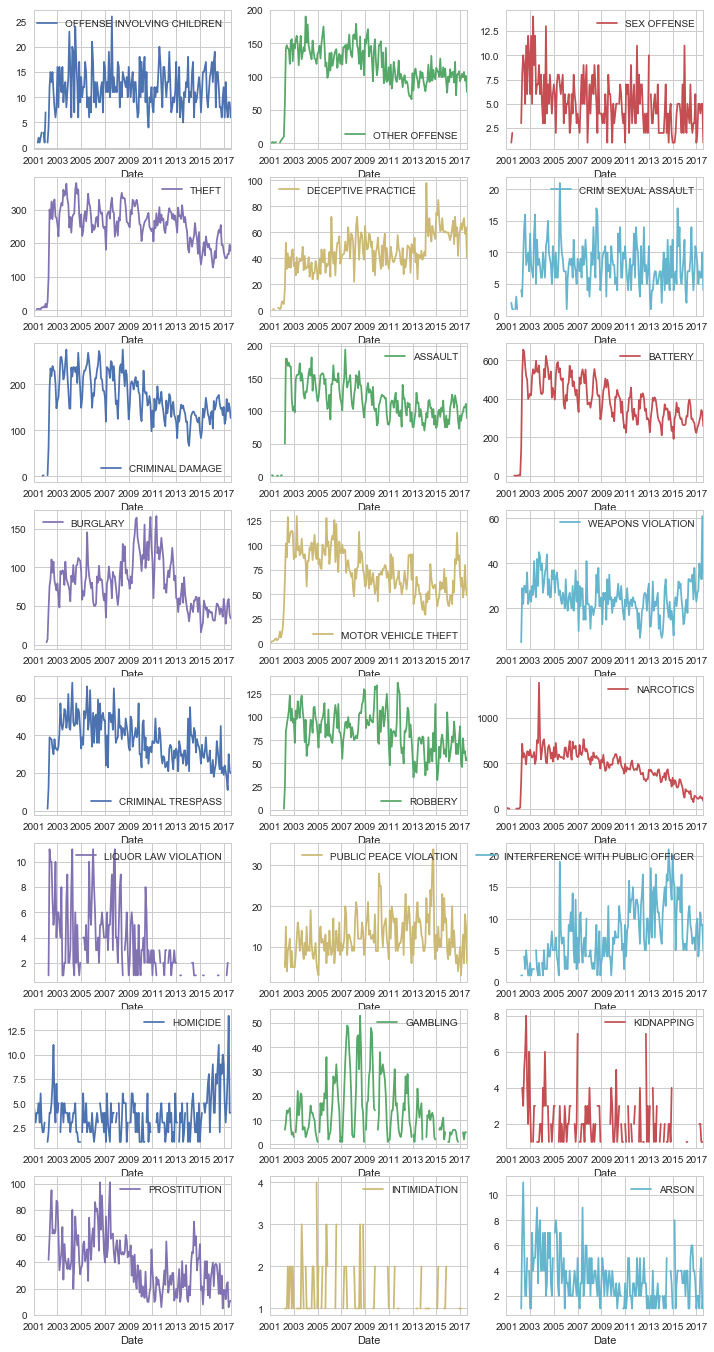

In [39]:
# plot top Austin crimes over time individually
Austin_crime_data.plot(figsize=(12, 24), subplots=True, layout=(-1, 3),\
                    sharex=False, sharey=False)
plt.show()

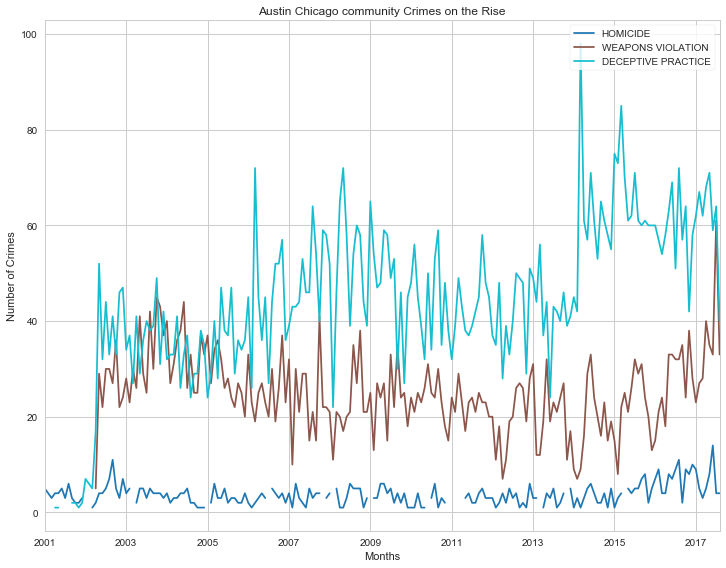

In [40]:
# plot Austin crimes on the rise
Austin_crime_data[['HOMICIDE', 'WEAPONS VIOLATION', 'DECEPTIVE PRACTICE']]\
.plot(figsize=(10,8), cmap='tab10')
plt.legend(loc='upper right', frameon=True)
plt.title('Austin Chicago community Crimes on the Rise')
plt.tight_layout()
plt.xlabel('Months')
plt.ylabel('Number of Crimes')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

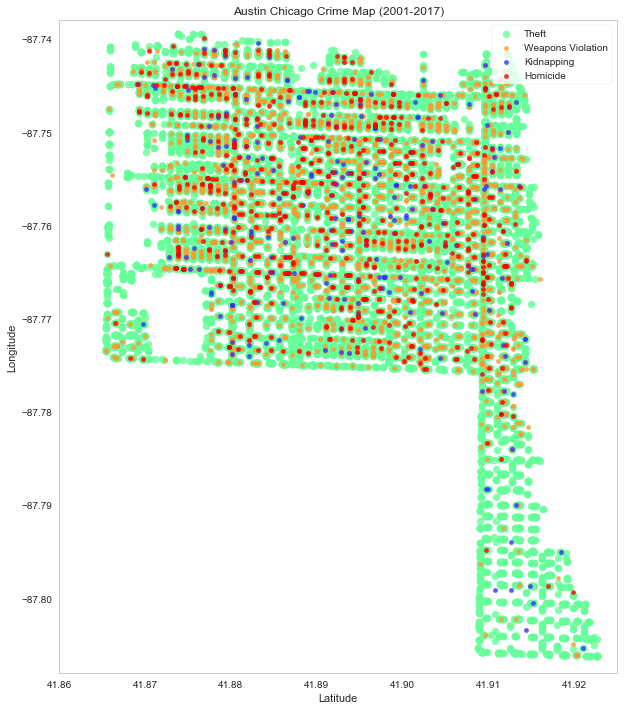

Wall time: 2.33 s


In [41]:
%%time

# get Austin crime geo data
Austin_crime_geo = Austin_crime[['PrimaryType', 'Latitude', 'Longitude']].dropna()
s1 = Austin_crime_geo[(Austin_crime_geo['PrimaryType']=='HOMICIDE')].compute()
s2 = Austin_crime_geo[(Austin_crime_geo['PrimaryType']=='WEAPONS VIOLATION')].compute()
s3 = Austin_crime_geo[(Austin_crime_geo['PrimaryType']=='KIDNAPPING')].compute()
s4 = Austin_crime_geo[(Austin_crime_geo['PrimaryType']=='THEFT')].compute()

# create Austin crime scatter map plot
fig,ax= plt.subplots(1, 1, figsize=(10,12))
plt.xlim(41.86, 41.925) # (minLat, maxLat)
plt.ylim(-87.808, -87.738) # (minLong, maxLong)
#ax.set_facecolor('black')

# plot thefts, homicides, kidnappings and sexual assaults
ax.scatter(s4['Latitude'], s4['Longitude'],\
           s=50, alpha=0.8, color='#66ff99', label='Theft')
ax.scatter(s2['Latitude'], s2['Longitude'],\
           s=20, alpha=0.8, color='#ff9933', label='Weapons Violation')
ax.scatter(s3['Latitude'], s3['Longitude'],\
           s=20, alpha=0.8, color='#3333ff', label='Kidnapping')
ax.scatter(s1['Latitude'], s1['Longitude'],\
           s=20, alpha=0.8, color='#ff0000', label='Homicide')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Austin Chicago Crime Map (2001-2017)')
plt.legend(loc='upper right', frameon=True)
plt.grid(linestyle = '--', linewidth = 0.05)
plt.show()

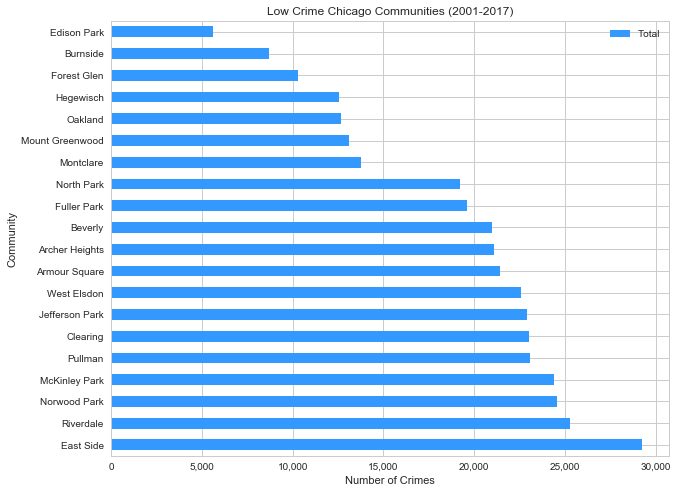

In [42]:
# plot 20 low crime communities
community_crime.tail(20).sort_values(by='Total', ascending=False)\
.plot(kind='barh', figsize=(10,8), color='#3399ff')
plt.title('Low Crime Chicago Communities (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Community')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

In [43]:
# group crime totals by Chicago 'sides'
crime_by_side = community_areas.groupby('Side').sum()\
.drop('CommunityArea', axis=1) # denotes column
crime_by_side.sort_values(by='Total', ascending=False)

,Total
Side,
West Side,1428846
Southwest Side,888977
South Side,795101
Far Southeast Side,680550
Far North Side,509413
North Side,417278
Central,367343
Far Southwest Side,366448
Northwest Side,333145


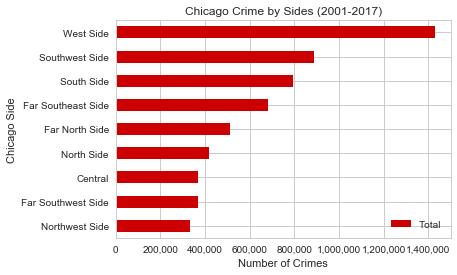

In [44]:
# plot crime by Chicago community sides
crime_by_side.sort_values(by='Total', ascending=True)\
.plot(kind='barh', figsize=(6,4), color='#cc0000')
plt.title('Chicago Crime by Sides (2001-2017)')
plt.xlabel('Number of Crimes')
plt.ylabel('Chicago Side')
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.show()

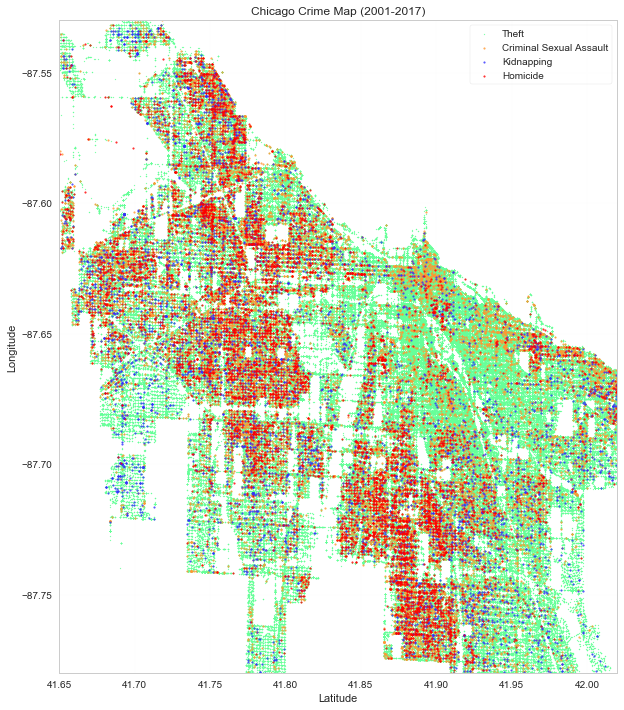

Wall time: 30.2 s


In [45]:
%%time

# get min/max lat and long
#minLat = crimes['Latitude'].min().compute()
#maxLat = crimes['Latitude'].max().compute()
#minLong = crimes['Longitude'].min().compute()
#maxLong = crimes['Longitude'].max().compute()

# get crime geo data
crime_geo = crimes[['PrimaryType', 'Latitude', 'Longitude']].dropna()

# get homicides
homicides = crime_geo[(crime_geo['PrimaryType']=='HOMICIDE')]\
.compute()

# get kidnappings
kidnappings = crime_geo[(crime_geo['PrimaryType']=='KIDNAPPING')]\
.compute()

# get criminal sexual assaults
sexual_assaults = crime_geo[(crime_geo['PrimaryType']=='CRIM SEXUAL ASSAULT')]\
.compute()

# get thefts
thefts = crime_geo[(crime_geo['PrimaryType']=='THEFT')]\
.compute()

# create scatter map plot
fig,ax= plt.subplots(1, 1, figsize=(10,12))
plt.xlim(41.65, 42.02) # (minLat, maxLat)
plt.ylim(-87.78, -87.53) # (minLong, maxLong)
#ax.set_facecolor('black')

# plot thefts, homicides, kidnappings and sexual assaults
ax.scatter(thefts['Latitude'], thefts['Longitude'],\
                            s=1, alpha=0.8, color='#66ff99', label='Theft')
ax.scatter(sexual_assaults['Latitude'], sexual_assaults['Longitude'],\
                            s=3, alpha=0.8, color='#ff9933', label='Criminal Sexual Assault')
ax.scatter(kidnappings['Latitude'], kidnappings['Longitude'],\
                            s=3, alpha=0.8, color='#3333ff', label='Kidnapping')
ax.scatter(homicides['Latitude'], homicides['Longitude'],\
                            s=3, alpha=0.8, color='#ff0000', label='Homicide')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.title('Chicago Crime Map (2001-2017)')
plt.legend(loc='upper right', frameon=True)
plt.grid(linestyle = '--', linewidth = 0.05)
plt.show()